In [1]:
import openmc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec


def tally_flux_2_df(path, tally_name, corriente):
    sp = openmc.StatePoint(path)
    tally = sp.get_tally(name=tally_name)
    df = tally.get_pandas_dataframe()
    if len(df.columns) == 7:
        df.columns = [
            "x",
            "y",
            "z",
            "nuclide",
            "score",
            "mean",
            "std.dev.",
        ]
    else:
        df.columns = [
            "x",
            "y",
            "z",
            "nuclide",
            "score",
            "mean",
        ]
        df["std.dev."] = 1000

    volumen_celda = (
        tally.filters[0]._mesh.total_volume / tally.filters[0]._mesh.num_mesh_cells
    )
    df["mean_norm"] = df["mean"] / volumen_celda * corriente
    df["std.dev._norm"] = df["std.dev."] / volumen_celda
    z_min = tally.filters[0]._mesh.lower_left[2]
    z_max = tally.filters[0]._mesh.upper_right[2]
    z = np.linspace(z_min, z_max, tally.filters[0]._mesh.num_mesh_cells + 1)
    z_midpoints = (z[:-1] + z[1:]) / 2
    df["z_midpoints"] = z_midpoints
    return df


def get_tally_agua(df_total, df_vacio):
    volumen_total = df_total["mean"].sum() / df_total["mean_norm"].sum()
    volumen_vacio = df_vacio["mean"].sum() / df_vacio["mean_norm"].sum()
    volumen_agua = volumen_total - volumen_vacio

    df_agua = df_total.copy()
    df_agua["mean"] = df_agua["mean"] - df_vacio["mean"]
    df_agua["std.dev."] = np.sqrt(
        df_agua["std.dev."] ** 2 + df_vacio["std.dev."] ** 2
    )  # Revisar esto si hace falta. No se reviso hasta el momento.
    df_agua["mean_norm"] = df_agua["mean"] / volumen_agua
    df_agua["std.dev._norm"] = df_agua["std.dev."] / volumen_agua

    return df_agua


def plot_flux(df_flux_total, df_flux_vacio, df_flux_agua, save=False):
    plt.figure(figsize=(10, 6))
    plt.plot(
        df_flux_agua["z_midpoints"],
        df_flux_agua["mean_norm"],
        label="Flujo en agua",
        color="blue",
    )
    plt.plot(
        df_flux_vacio["z_midpoints"],
        df_flux_vacio["mean_norm"],
        label="Flujo en vacío",
        color="red",
    )
    plt.plot(
        df_flux_total["z_midpoints"],
        df_flux_total["mean_norm"],
        label="Flujo total",
        color="green",
    )
    plt.xlabel("z [cm]")
    plt.ylabel("Flujo [cm$^{-2}$ s$^{-1}$]")
    plt.title("Flujo en funcion de z")
    plt.legend()
    plt.grid()
    plt.yscale("log")
    if save:
        plt.savefig(
            "flujos1.png",
            bbox_inches="tight",
            dpi=600,
        )
    plt.show()


def plot_flux_comparison(
    df_total_orig,
    df_total_sint,
    df_vacio_orig,
    df_vacio_sint,
    df_agua_orig,
    df_agua_sint,
    z0: float,
    save=True,
) -> None:
    """
    Compara gráficamente el flujo entre simulaciones original y sintética para las regiones:
    total, agua y vacío, e incluye errores relativos (en %), interpolando sobre un eje z común.

    El dominio va desde z0_sint hasta el mínimo z_max de ambas curvas.
    """

    def compute_relative_error(
        df_orig, df_sint, z0_sint: float, num_interp_points: int = 1000
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Calcula el error relativo entre los perfiles original y sintético de flujo,
        interpolando ambos sobre una grilla común en z.
        """
        z_min = z0_sint
        z_max = min(df_orig["z_midpoints"].max(), df_sint["z_midpoints"].max())
        z_interp = np.linspace(z_min, z_max, num_interp_points)

        interp_orig = np.interp(z_interp, df_orig["z_midpoints"], df_orig["mean_norm"])
        interp_sint = np.interp(z_interp, df_sint["z_midpoints"], df_sint["mean_norm"])

        # Crear máscara para valores no cero
        mask_nonzero = interp_orig != 0

        # Inicializar el array de error relativo con NaN
        err_rel = np.full_like(interp_orig, fill_value=np.nan)

        # Calcular el error relativo donde interp_orig no es cero
        err_rel[mask_nonzero] = (
            100
            * (interp_orig[mask_nonzero] - interp_sint[mask_nonzero])
            / interp_orig[mask_nonzero]
        )

        # Asignar infinito donde interp_orig es cero
        err_rel[~mask_nonzero] = np.inf

        return z_interp, err_rel

    def redondear_a_una_cifra(x: float) -> float:
        """
        Redondea un número positivo a una sola cifra significativa.
        Por ejemplo:
        - 3.76 → 4
        - 0.084 → 0.08
        - 123 → 100
        """
        if x == 0:
            return 0
        exponente = np.floor(np.log10(abs(x)))
        return round(x / 10**exponente) * 10**exponente

    fig = plt.figure(figsize=(16 * 1.25, 9 * 0.8))
    gs = gridspec.GridSpec(2, 3, height_ratios=[2.5, 1])
    axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]

    plt.subplots_adjust(
        left=0.07, right=0.95, top=0.94, bottom=0.00, wspace=0.3, hspace=0.25
    )

    nombres = ["Total", "Agua", "Vacío"]
    df_orig_all = [df_total_orig, df_agua_orig, df_vacio_orig]
    df_sint_all = [df_total_sint, df_agua_sint, df_vacio_sint]

    for i in range(3):
        df_orig = df_orig_all[i]
        df_sint = df_sint_all[i]

        # Establecer límites comunes en eje x
        z_min = 0
        z_max = max(df_orig["z_midpoints"].max(), df_sint["z_midpoints"].max())
        z_min = z_min - (z_max - z_min) * 0.05
        z_max = z_max + (z_max - z_min) * 0.05

        # Curvas originales y sintéticas
        axs[i].plot(
            df_orig["z_midpoints"],
            df_orig["mean_norm"],
            label="Original",
            color="blue",
            linestyle="--",
        )
        axs[i].plot(
            df_sint["z_midpoints"],
            df_sint["mean_norm"],
            label="Sintético",
            color="red",
            linestyle="-",
        )
        axs[i].set_title(f"Flujo {nombres[i]} vs. z")
        axs[i].set_ylabel(r"$\phi$ [cm$^{-2}$ s$^{-1}$]")
        axs[i].set_yscale("log")
        axs[i].set_xlabel("z [cm]")
        axs[i].grid(True, which="both", linestyle="--", linewidth=0.5)
        axs[i].legend()
        axs[i].set_xlim(z_min, z_max)  # sincronizar eje x

        # Error relativo interpolado
        z_interp, err_rel = compute_relative_error(df_orig, df_sint, z0)
        axs[i + 3].plot(z_interp, err_rel, color="black")
        axs[i + 3].axhline(0, color="gray", linestyle="--", linewidth=1)
        axs[i + 3].set_ylabel("Error relativo [\%]")

        # Cálculo de límites del eje y con margen simétrico (rango total)
        err_min = np.nanmin(err_rel)
        err_max = np.nanmax(err_rel)
        y_range = err_max - err_min
        y_margin = y_range * 0.05

        y_lim_min = max(err_min - y_margin, -100)
        y_lim_max = min(err_max + y_margin, 100)
        axs[i + 3].set_ylim(y_lim_min, y_lim_max)

        # Calcular paso = 20% del rango, redondeado a 1 cifra significativa
        paso_base = 0.2 * (y_lim_max - y_lim_min)

        # Redondear a 1 cifra significativa
        paso = max(redondear_a_una_cifra(paso_base), 1e-6)

        # Establecer ticks manuales
        ticks_y = np.arange(np.floor(y_lim_min), np.ceil(y_lim_max) + paso, paso)

        # Asegurarse de que 0 esté en los ticks
        if not np.any(np.isclose(ticks_y, 0)):
            ticks_y = np.sort(np.append(ticks_y, 0.0))

        axs[i + 3].set_yticks(ticks_y)

        axs[i + 3].grid(True, which="both", linestyle="--", linewidth=0.5)
        axs[i + 3].set_xlim(z_min, z_max)  # sincronizar eje x

    if save:
        plt.savefig("comparacion_flujos.png", bbox_inches="tight", dpi=600)
    plt.show()

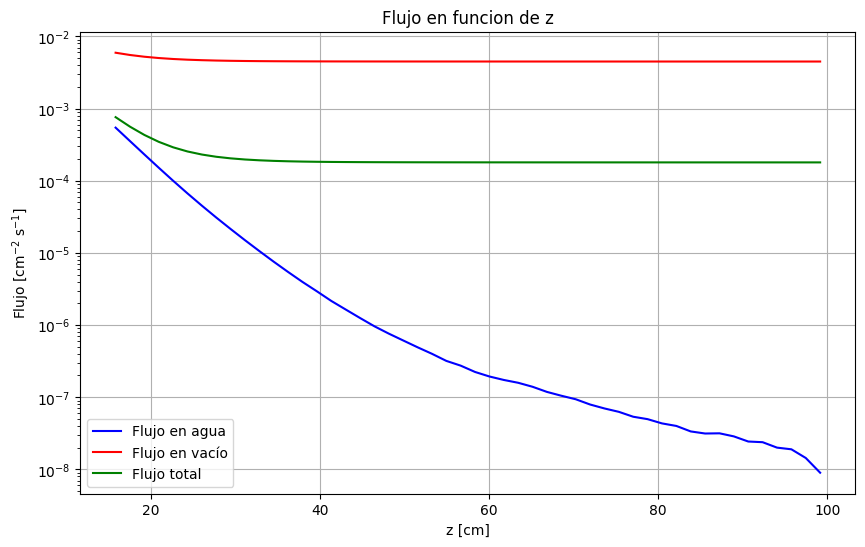

In [2]:
# original
path_original = "statepoint.1250.h5"
corriente_original = 1.0

df_original_total = tally_flux_2_df(path_original, "flux_total", corriente_original)
df_original_vacio = tally_flux_2_df(path_original, "flux_vacio", corriente_original)
df_original_agua = get_tally_agua(
    df_original_total, df_original_vacio
)  # Flujo en agua

# %matplotlib widget
plot_flux(
    df_original_total,
    df_original_vacio,
    df_original_agua,
    save=False,
)  # Graficar flujos